Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Total sentiments in train set:
Sentiment
positive    4058
neutral      453
negative     390
Name: count, dtype: int64

Total sentiments in test set:
Sentiment
positive    1699
neutral      211
negative     191
Name: count, dtype: int64


Epoch 1/1
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()




Train loss 0.38439874748469954 accuracy 0.8665578453376862
[[ 153   32    6]
 [  62  104   45]
 [   9   74 1616]]
              precision    recall  f1-score   support

    negative       0.68      0.80      0.74       191
     neutral       0.50      0.49      0.49       211
    positive       0.97      0.95      0.96      1699

    accuracy                           0.89      2101
   macro avg       0.72      0.75      0.73      2101
weighted avg       0.90      0.89      0.89      2101



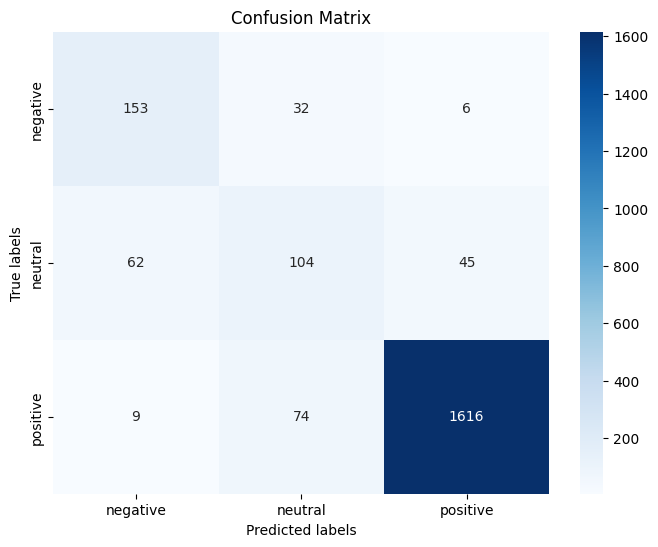

In [11]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models import KeyedVectors
import re
import nltk
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns


# Mount Google Drive to access files
drive.mount('/content/drive')

# Load dataset
data_path = '/content/drive/My Drive/experiment/trip-advisor.csv'
data = pd.read_csv(data_path)

# Preprocessing: Text Cleaning, Tokenization, and Normalization
nltk.download('punkt')

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

data['Cleaned_Review'] = data['Review'].apply(clean_text)

# Adjust labels for sentiment analysis
data['Sentiment'] = pd.cut(data['Rating'], bins=[-np.inf, 2, 3, np.inf], labels=['negative', 'neutral', 'positive'], right=False)

# Split data into train and test sets (70% train, 30% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Cleaned_Review'], data['Sentiment'], test_size=0.3, random_state=42)

# Print total sentiment in train and test set
print("\nTotal sentiments in train set:")
print(train_labels.value_counts())

print("\nTotal sentiments in test set:")
print(test_labels.value_counts())

# Load FastText model
fasttext_model_path = '/content/drive/My Drive/experiment/wiki-news-300d-1M.vec'
fasttext_vectors = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=False)

# Convert text data to FastText vectors (average of word vectors)
def text_to_vector(text):
    tokens = nltk.word_tokenize(text.lower())
    vectors = [fasttext_vectors[word] for word in tokens if word in fasttext_vectors]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

train_vectors = np.array([text_to_vector(text) for text in train_texts])
test_vectors = np.array([text_to_vector(text) for text in test_texts])

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear = nn.Linear(300, 768)
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Linear(768 * 2, n_classes)  # Combine BERT and FastText embeddings

    def forward(self, input_ids, attention_mask, fasttext_embeddings):
        # BERT
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.pooler_output

        # FastText
        fasttext_embeddings = self.linear(fasttext_embeddings)
        fasttext_embeddings = self.dropout(fasttext_embeddings)

        # Combine BERT and FastText embeddings
        combined = torch.cat((pooled_output, fasttext_embeddings), dim=1)
        output = self.classifier(combined)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(len(data['Sentiment'].unique()))
model = model.to(device)

class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings):
        self.reviews = reviews
        self.ratings = ratings
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        rating = self.ratings.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=512,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        fasttext_vector = torch.tensor(text_to_vector(review), dtype=torch.float)

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'fasttext_embeddings': fasttext_vector,
            'labels': torch.tensor(0 if rating == 'negative' else 1 if rating == 'neutral' else 2, dtype=torch.long)  # Adjusted labels
        }

def create_data_loader(reviews, ratings, batch_size):
    ds = ReviewDataset(reviews, ratings)
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

BATCH_SIZE = 8
train_data_loader = create_data_loader(train_texts, train_labels, BATCH_SIZE)
test_data_loader = create_data_loader(test_texts, test_labels, BATCH_SIZE)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)

# Training loop
EPOCHS = 1

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        fasttext_embeddings = d["fasttext_embeddings"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, fasttext_embeddings=fasttext_embeddings)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

print("\n")

print(f'Epoch {1}/{EPOCHS}')
print('-' * 10)

train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    None,
    len(train_texts)
)

print("\n")

print(f'Train loss {train_loss} accuracy {train_acc}')


def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            fasttext_embeddings = d["fasttext_embeddings"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, fasttext_embeddings=fasttext_embeddings)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            real_values.extend(labels)

    return torch.stack(predictions).cpu(), torch.stack(real_values).cpu()

y_pred, y_true = get_predictions(model, test_data_loader)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)
print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

# Visualize Confusion Matrix
labels = ['negative', 'neutral', 'positive']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
